In [22]:
import configparser
import os
from joblib import dump, load
import json
from tqdm import tqdm
from helpers.helper_functions import *
from helpers.helper_classes import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
import numpy as np
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import scienceplots
import latex
# Set plotting parameters
plt.style.use(['science', 'ieee']) 
plt.rcParams['figure.dpi'] = 100

pd.set_option('display.max_rows', 200)

# Read config.ini file
config = configparser.ConfigParser()
config.read('src/config.ini')
# os.chdir(config['PATH']['ROOT_DIR'])

# # Load data
df = pd.read_csv(config['PATH']['DATA_DIR'] + '/dataset_mood_smartphone.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# time to datetime
df['time'] = pd.to_datetime(df['time'])

# get all duplicate observations for the same time and person
df_dupes = df[df.duplicated(subset=['time', 'id', 'variable'], keep=False)].copy()

# drop duplicates
df.drop_duplicates(subset=['time', 'id', 'variable'], keep='first', inplace=True)

In [23]:
# TODO: 
# DONE: Forward fill valence and arousal
# DONE: Remove appCat.builtin negative values
# DONE: Remove appCat outliers
# Impute valence, arousal and mood
# Impute long term missing values with mean instead of ffill (for valence and arousal)
# Aggregate to daily mood
# Decide on aggregation method for each variable

In [24]:
all_id = df['id'].unique()
# subset of df with only 5 id's
df_sub = df[df['id'].isin(all_id[:5])].copy()

## Extreme values appCat variables
There are many outliers in the appCat variables, this is not ideal for numerical stability. We will one hot encode these outliers per variable and remove the outlier from the original observation

In [25]:
#  We will one hot encode these outliers per variable and remove the outlier from the original observation
#  Moreover we will remove all negative values

df_agg_nocap = load(config['PATH']['DATA_DIR'] + '/full_df_agg_nocap.joblib')
df_cleaned = df.copy()

all_vars = df['variable'].unique()
appVars = [var for var in all_vars if 'appCat' in var]
appVars + ['screen']

for var in appVars:
    df_var_cur = df[df['variable'] == var].copy()

    # Get all idx where value is smaller than 0
    idx = df_var_cur[df_var_cur['value'] < 0].index
    df.drop(idx, axis=0, inplace=True)

    # Get all idx where value is larger than 97.5th percentile
    upper_bound = df_agg_nocap[var + '_sum'].quantile(0.95)
    idx_98 = df_var_cur[df_var_cur['value'] > upper_bound].index
    mean_cur = df_var_cur['value'].mean()

    # Change variable name to var_outlier
    # df.loc[idx_98, 'variable'] = var + '_outlier'
    df_cleaned.loc[idx_98, 'value'] = mean_cur
    df_var_cur.loc[idx_98, 'value'] = mean_cur	
    
    print(f"var: {var} \n {df_var_cur['value'].describe()}")




var: appCat.builtin 
 count    91288.000000
mean        13.467874
std        285.094026
min     -82798.871000
25%          2.020000
50%          4.038000
75%          9.922000
max       3690.262000
Name: value, dtype: float64
var: appCat.communication 
 count    74276.000000
mean        42.965233
std        114.306008
min          0.006000
25%          5.218000
50%         16.225500
75%         45.471000
max       6053.176000
Name: value, dtype: float64
var: appCat.entertainment 
 count    27125.000000
mean        34.909811
std        130.391579
min         -0.011000
25%          1.334000
50%          3.391000
75%         14.922000
max       3266.010000
Name: value, dtype: float64
var: appCat.finance 
 count    939.000000
mean      14.572142
std       16.376790
min        0.131000
25%        4.072000
50%        8.026000
75%       20.155000
max       88.543000
Name: value, dtype: float64
var: appCat.game 
 count    813.000000
mean      75.186481
std       84.286495
min        1.003000
2

## Impute valence, arousal and mood using ARMA and Kalman smoother.
* Fit ARMA and obtain state space model for each series
* Add in the NA for missing values
* Impute using kalman smoother.

In [26]:
series = ['mood', 'circumplex.arousal', 'circumplex.valence']
df_sub = df[df['id'] == 'AS14.01']

# Imputation
df_imputed, compare_df_mood = impute_ARMA(df_cleaned, 'mood', verbose = 0)
df_imputed, compare_df_valence = impute_linear(df_imputed, 'circumplex.valence', verbose = 0)
df_imputed, compare_df_arousal = impute_linear(df_imputed, 'circumplex.arousal', verbose = 0)

# Remove leading and trailing partial days
df_imputed_cleaned = drop_partial_obs(df_imputed)

# Save df with joblib
dump(df_imputed_cleaned, config['PATH']['DATA_DIR'] + '/df_cleaned_cap2.joblib')

Obtaining ARMA parameters for variable:  mood


100%|██████████| 27/27 [00:59<00:00,  2.21s/it]


Creating missing values for variable:  mood


100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


Imputing missing values for variable:  mood


100%|██████████| 27/27 [00:02<00:00, 11.84it/s]


Creating missing values for variable:  circumplex.valence


100%|██████████| 27/27 [00:01<00:00, 16.89it/s]


Creating missing values for variable:  circumplex.arousal


100%|██████████| 27/27 [00:45<00:00,  1.68s/it]

Removed 4906 observations


['./data/df_cleaned_cap2.joblib']

C:\Users\caspa\AppData\Local\Temp\ipykernel_18996\3288215320.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmp_df['missing'] = ((~preceded_by_nan) & non_nan & (~followed_by_nan)).astype(int)
C:\Users\caspa\AppData\Local\Temp\ipykernel_18996\3288215320.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmp_df['missing'] = ((~preceded_by_nan) & non_nan & (~followed_by_nan)).astype(int)


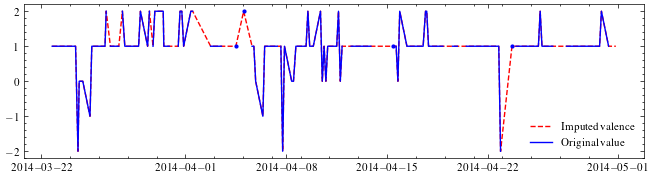

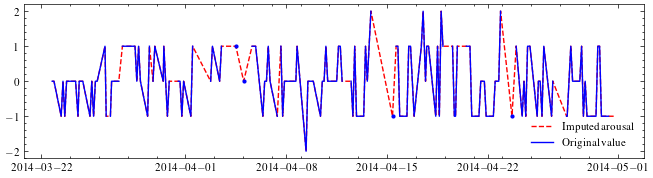

In [6]:
def plot_imputation(person, compare_df, label_impute, title = False, save_name = None):
    for person in person:
    # for person in df_imputed['id'].unique():	
        cmp_df = compare_df[person][3:]

        # Create a boolean series with True for non-NaN values
        non_nan = ~cmp_df['value'].isna()

        # Check if a non-NaN value is both preceded and followed by a NaN value
        preceded_by_nan = non_nan.shift(1, fill_value=False)
        followed_by_nan = non_nan.shift(-1, fill_value=False)
        cmp_df['missing'] = ((~preceded_by_nan) & non_nan & (~followed_by_nan)).astype(int)
        singles_df = cmp_df.loc[cmp_df['missing'] == 1]

        idx_nan = np.isnan(cmp_df['value'])
        nan_df = cmp_df.loc[idx_nan]

        # Plot
        plt.figure(figsize=(8,2))
        plt.plot(cmp_df['time'], cmp_df['smoothed'], color = 'r', label = label_impute, linestyle = '--')
        plt.plot(cmp_df['time'], cmp_df['value'], color = 'b', label = 'Original value', linestyle = '-')
        plt.plot(singles_df['time'], singles_df['value'], color = 'b', marker = 'o', linestyle = 'None', markersize = 2)
        plt.legend(loc='lower right')

        if title:
            plt.title('Person: ' + str(person) + ' Variable: ' + 'circumplex.valence')

        # save figure
        if save_name:
            plt.savefig('figures/' + save_name + '.pdf', bbox_inches='tight')
        # plt.title('Person: ' + str(person) + ' Variable: ' + 'mood')

plot_imputation(['AS14.23'], compare_df_valence, 'Imputed valence', save_name = 'imputed_valence')
plot_imputation(['AS14.23'], compare_df_arousal, 'Imputed arousal', save_name='imputed_arousal')


In [11]:
# Describe all variables
vars = df_imputed_cleaned['variable'].unique()
for var in vars:
    print(var)
    print(df_imputed_cleaned[df_imputed_cleaned['variable'] == var]['value'].describe())

mood
count    6197.000000
mean        6.996747
std         0.995489
min         0.000000
25%         6.733072
50%         7.000000
75%         8.000000
max        10.000000
Name: value, dtype: float64
circumplex.arousal
count    6197.000000
mean       -0.102734
std         1.034091
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
circumplex.valence
count    6197.000000
mean        0.687792
std         0.652553
min        -2.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
activity
count    22937.000000
mean         0.116000
std          0.186974
min          0.000000
25%          0.000000
50%          0.021739
75%          0.158333
max          1.000000
Name: value, dtype: float64
screen
count    96565.000000
mean        75.331443
std        253.832505
min          0.035000
25%          5.322000
50%         20.043000
75%         62.52

In [28]:
res_dict = {}
for person in tqdm(df_imputed['id'].unique()):
    df_person = df_imputed[df_imputed['id'] == person]
    df_person = df_person.sort_values(by='time')

    n_vars_df = pd.DataFrame(columns=['time', 'n_variables'])
    for day in df_person['time'].dt.date.unique():
        df_day = df_person[df_person['time'].dt.date == day]
        n_variables = len(df_day['variable'].unique())
        n_vars_df = pd.concat([n_vars_df, pd.DataFrame({'time': [day], 'n_variables': [n_variables]})])

    res_dict[person] = n_vars_df
    





100%|██████████| 27/27 [00:15<00:00,  1.79it/s]


In [29]:
df_imputed['id'].unique()

array(['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07',
       'AS14.08', 'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15',
       'AS14.16', 'AS14.17', 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24',
       'AS14.25', 'AS14.26', 'AS14.27', 'AS14.28', 'AS14.29', 'AS14.30',
       'AS14.31', 'AS14.32', 'AS14.33'], dtype=object)

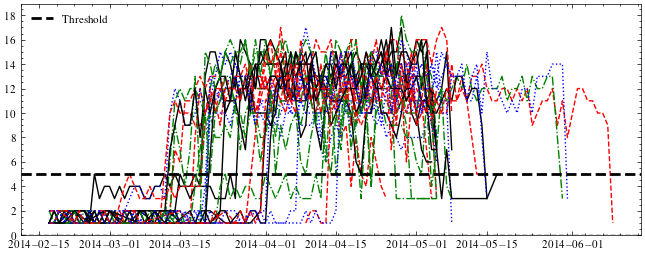

In [53]:
# Plot n_variables vs time for all people in one figure
# No legend

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(8,3))
for person in df_imputed['id'].unique():
    df_person = res_dict[person]
    ax.plot(df_person['time'], df_person['n_variables'])
ax.axhline(0, color = 'black', linestyle = '--')
ax.set_ylim(bottom=0)
ax.axhline(5, color = 'black', linestyle = '--', linewidth = 2, label = 'Threshold')
ax.legend(loc='upper left')
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig('figures/n_variables.pdf', bbox_inches='tight')